In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow_addons as tfa
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sn
import glob
import sys
import os
import math
import gc
import sys
import sklearn
import scipy
from tqdm.notebook import tqdm
from sklearn.model_selection import train_test_split, GroupShuffleSplit 

print(f'Tensorflow V{tf.__version__}')
print(f'Keras V{tf.keras.__version__}')
print(f'Python V{sys.version}')

Tensorflow V2.11.0
Keras V2.11.0
Python V3.7.12 | packaged by conda-forge | (default, Oct 26 2021, 06:08:53) 
[GCC 9.4.0]


# Config

In [2]:
rows = 543
dim = 3
SEED = 42
classes = 250
inputSize = 32
batch_signs = 4
batch_size = 256
model_epochs = 100
lr_limit = 1e-3
warmup_epochs = 0
wt_decay_ratio = 0.05


# Load Train Data csv

In [3]:
train = pd.read_csv('/kaggle/input/asl-signs/train.csv')
train_len = len(train)
print(f'train_len: {train_len}')

train_len: 94477


# Add File Path

In [4]:
# Get complete file path to file, add kaggle link to make complete link and column nase is file_path now
def get_complete_path(path):
    return f'/kaggle/input/asl-signs/{path}'
train['file_path'] = train['path'].apply(get_complete_path)

# Ordinally Encode Sign

In [5]:
# Add ordinally Encoded Sign (assign number to each sign name out of the 250 possible signs
# Add ordinally Encoded Sign (assign number to each sign name)
train['sign_ord'] = train['sign'].astype('category').cat.codes

# Dictionaries to translate sign <-> ordinal encoded sign
ORD2SIGN_dict = train[['sign_ord', 'sign']].set_index('sign_ord').squeeze().to_dict()

In [6]:
display(train.head(10))
display(train.info())

,path,participant_id,sequence_id,sign,file_path,sign_ord
0,train_landmark_files/26734/1000035562.parquet,26734,1000035562,blow,/kaggle/input/asl-signs/train_landmark_files/2...,25
1,train_landmark_files/28656/1000106739.parquet,28656,1000106739,wait,/kaggle/input/asl-signs/train_landmark_files/2...,232
2,train_landmark_files/16069/100015657.parquet,16069,100015657,cloud,/kaggle/input/asl-signs/train_landmark_files/1...,48
3,train_landmark_files/25571/1000210073.parquet,25571,1000210073,bird,/kaggle/input/asl-signs/train_landmark_files/2...,23
4,train_landmark_files/62590/1000240708.parquet,62590,1000240708,owie,/kaggle/input/asl-signs/train_landmark_files/6...,164
5,train_landmark_files/26734/1000241583.parquet,26734,1000241583,duck,/kaggle/input/asl-signs/train_landmark_files/2...,67
6,train_landmark_files/26734/1000255522.parquet,26734,1000255522,minemy,/kaggle/input/asl-signs/train_landmark_files/2...,143
7,train_landmark_files/32319/1000278229.parquet,32319,1000278229,lips,/kaggle/input/asl-signs/train_landmark_files/3...,134
8,train_landmark_files/37055/100035691.parquet,37055,100035691,flower,/kaggle/input/asl-signs/train_landmark_files/3...,86
9,train_landmark_files/29302/100039661.parquet,29302,100039661,time,/kaggle/input/asl-signs/train_landmark_files/2...,220


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 94477 entries, 0 to 94476
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   path            94477 non-null  object
 1   participant_id  94477 non-null  int64 
 2   sequence_id     94477 non-null  int64 
 3   sign            94477 non-null  object
 4   file_path       94477 non-null  object
 5   sign_ord        94477 non-null  int16 
dtypes: int16(1), int64(2), object(3)
memory usage: 3.8+ MB


None

# Landmark Indices

In [7]:
# The different type of hand movements are left hand, right hand, pose, and lips int the database. 
# types - 'left_hand', 'pose', 'right_hand'

# Constants defining landmark indices based on a library like MediaPipe
lips_index_v1 = np.array([
    61, 185, 40, 39, 37, 0, 267, 269, 270, 409,
    291, 146, 91, 181, 84, 17, 314, 405, 321, 375,
    78, 191, 80, 81, 82, 13, 312, 311, 310, 415,
    95, 88, 178, 87, 14, 317, 402, 318, 324, 308,
])
left_hand_index_v1 = np.arange(468, 489)
right_hand_index_v1 = np.arange(522, 543)
left_pose_index_v1 = np.array([502, 504, 506, 508, 510])
right_pose_index_v1 = np.array([503, 505, 507, 509, 511])

# Concatenate indices for the dominant hands
left_dominant_index = np.concatenate((lips_index_v1, left_hand_index_v1, left_pose_index_v1))
right_dominant_index = np.concatenate((lips_index_v1, right_hand_index_v1, right_pose_index_v1))
hand_index = np.concatenate((left_hand_index_v1, right_hand_index_v1))
num_columns = left_dominant_index.size

# Processed data indices using np.isin for optimized searching and mapping
def get_processed_indices(dominant_indices, specific_indices):
    return np.flatnonzero(np.isin(dominant_indices, specific_indices))

# Calculate processed indices
lips_index = get_processed_indices(left_dominant_index, lips_index_v1)
left_hand_index = get_processed_indices(left_dominant_index, left_hand_index_v1)
right_hand_index = get_processed_indices(left_dominant_index, right_hand_index_v1)
hands_all_index = get_processed_indices(left_dominant_index, hand_index)
pose_index = get_processed_indices(left_dominant_index, left_pose_index_v1)


# Process Data Tensorflow

In [8]:
#defined by the google Competition 
frame_rows = 543  # number of landmarks per frame

def load_relevant_data_subset(pq_path, columns=['x', 'y', 'z']):
    try:
        data = pd.read_parquet(pq_path, columns=columns)
        n_frames = data.shape[0] // frame_rows
        if data.shape[0] % frame_rows != 0:
            raise ValueError("Total number of rows is not a multiple of frame_rows.")
        reshaped_data = data.values.reshape(n_frames, frame_rows, len(columns))
        return reshaped_data.astype(np.float32)
    except Exception as e:
        print(f"An error occurred: {e}")
        return None

In [9]:
class PreprocessLayer(tf.keras.layers.Layer):
    def __init__(self):
        super(PreprocessLayer, self).__init__()
        normalisation_correction = tf.constant([
            # Add 0.50 to left hand (original right hand) and substract 0.50 of right hand (original left hand)
            [0] * len(lips_index) + [0.50] * len(left_hand_index) + [0.50] * len(pose_index),
            # Y coordinates stay intact
            [0] * len(left_dominant_index),
            # Z coordinates stay intact
            [0] * len(left_dominant_index)],dtype=tf.float32 )
        self.normalisation_correction = tf.transpose(normalisation_correction, [1,0])
        
    def pad_edge(self, t, repeats, side):
        if side == 'LEFT':
            return tf.concat((tf.repeat(t[:1], repeats=repeats, axis=0), t), axis=0)
        elif side == 'RIGHT':
            return tf.concat((t, tf.repeat(t[-1:], repeats=repeats, axis=0)), axis=0)
    
    @tf.function(
        input_signature=(tf.TensorSpec(shape=[None,rows,dim], dtype=tf.float32),),
    )
    def call(self, data0):
        # Number of Frames in Video
        n_frames0 = tf.shape(data0)[0]
        
        # Find dominant hand by comparing summed absolute coordinates
        left_hand_sum = tf.math.reduce_sum(tf.where(tf.math.is_nan(tf.gather(data0, left_hand_index_v1, axis=1)), 0, 1))
        right_hand_sum = tf.math.reduce_sum(tf.where(tf.math.is_nan(tf.gather(data0, right_hand_index_v1, axis=1)), 0, 1))
        left_dominant = left_hand_sum >= right_hand_sum
        
        # Count non NaN Hand values in each frame for the dominant hand
        if left_dominant:
            total_nonnan = tf.math.reduce_sum(
                    tf.where(tf.math.is_nan(tf.gather(data0, left_hand_index_v1, axis=1)), 0, 1),
                    axis=[1, 2],
                )
        else:
            total_nonnan = tf.math.reduce_sum(
                    tf.where(tf.math.is_nan(tf.gather(data0, right_hand_index_v1, axis=1)), 0, 1),
                    axis=[1, 2],
                )
        
        # Find frames indices with coordinates of dominant hand
        frames_indices = tf.where(total_nonnan > 0)
        frames_indices = tf.squeeze(frames_indices, axis=1)
        # Filter frames
        data = tf.gather(data0, frames_indices, axis=0)
        
        # Cast Indices in float32 to be compatible with Tensorflow Lite
        frames_indices = tf.cast(frames_indices, tf.float32)
        # Normalize to start with 0
        frames_indices -= tf.reduce_min(frames_indices)
        
        # Number of Frames in Filtered Video
        n_frames = tf.shape(data)[0]
        
        # Gather Relevant Landmark Columns
        if left_dominant:
            data = tf.gather(data, left_dominant_index, axis=1)
        else:
            data = tf.gather(data, right_dominant_index, axis=1)
            data = (
                    self.normalisation_correction + (
                        (data - self.normalisation_correction) * tf.where(self.normalisation_correction != 0, -1.0, 1.0))
                )
        
        # Video fits in inputSize
        if n_frames < inputSize:
            # Pad With -1 to indicate padding
            frames_indices = tf.pad(frames_indices, [[0, inputSize-n_frames]], constant_values=-1)
            # Pad Data With Zeros
            data = tf.pad(data, [[0, inputSize-n_frames], [0,0], [0,0]], constant_values=0)
            # Fill NaN Values With 0
            data = tf.where(tf.math.is_nan(data), 0.0, data)
            return data, frames_indices
        # Video needs to be downsampled to inputSize
        else:
            # Repeat
            if n_frames < inputSize**2:
                repeats = tf.math.floordiv(inputSize * inputSize, n_frames0)
                data = tf.repeat(data, repeats=repeats, axis=0)
                frames_indices = tf.repeat(frames_indices, repeats=repeats, axis=0)

            # Pad To Multiple Of Input Size
            pool_size = tf.math.floordiv(len(data), inputSize)
            if tf.math.mod(len(data), inputSize) > 0:
                pool_size += 1

            if pool_size == 1:
                pad_size = (pool_size * inputSize) - len(data)
            else:
                pad_size = (pool_size * inputSize) % len(data)

            # Pad Start/End with Start/End value
            pad_left = tf.math.floordiv(pad_size, 2) + tf.math.floordiv(inputSize, 2)
            pad_right = tf.math.floordiv(pad_size, 2) + tf.math.floordiv(inputSize, 2)
            if tf.math.mod(pad_size, 2) > 0:
                pad_right += 1

            # Pad By Concatenating Left/Right Edge Values
            data = self.pad_edge(data, pad_left, 'LEFT')
            data = self.pad_edge(data, pad_right, 'RIGHT')

            # Pad Non Empty Frame Indices
            frames_indices = self.pad_edge(frames_indices, pad_left, 'LEFT')
            frames_indices = self.pad_edge(frames_indices, pad_right, 'RIGHT')

            # Reshape to Mean Pool
            data = tf.reshape(data, [inputSize, -1, num_columns, dim])
            frames_indices = tf.reshape(frames_indices, [inputSize, -1])

            # Mean Pool
            data = tf.experimental.numpy.nanmean(data, axis=1)
            frames_indices = tf.experimental.numpy.nanmean(frames_indices, axis=1)

            # Fill NaN Values With 0
            data = tf.where(tf.math.is_nan(data), 0.0, data)
            
            return data, frames_indices
    
preprocess_layer = PreprocessLayer()

In [10]:
def get_data(file_path):
    data = preprocess_layer(load_relevant_data_subset(file_path))
    return data

# Create Dataset

In [11]:
def preprocess_data():
    # Initialize data structures
    X = np.zeros((train_len, inputSize, num_columns, dim), dtype=np.float32)
    y = np.zeros(train_len, dtype=np.int32)
    frame_indices = np.full((train_len, inputSize), -1, dtype=np.float32)

    # Process each sample
    for row_idx, (file_path, sign_ord) in enumerate(tqdm(train[['file_path', 'sign_ord']].values)):
        if row_idx % 5000 == 0:
            print(f'Processing {row_idx}/{train_len} samples')

        data, frame_indices_1 = get_data(file_path)
        if np.isnan(data).any():
            raise ValueError(f'NaN values found at index {row_idx}')

        X[row_idx] = data
        y[row_idx] = sign_ord
        frame_indices[row_idx] = frame_indices_1

    # Save arrays to files
    np.save('X.npy', X)
    np.save('y.npy', y)
    np.save('frame_indices.npy', frame_indices)

    return X, y, frame_indices

def split_data(X, y, groups):
    splitter = GroupShuffleSplit(test_size=0.10, n_splits=2, random_state=42)
    train_idxs, val_idxs = next(splitter.split(X, y, groups=groups))
    return train_idxs, val_idxs

def save_split_data(X, y, frame_indices, train_idxs, val_idxs):
    np.save('X_train.npy', X[train_idxs])
    np.save('y_train.npy', y[train_idxs])
    np.save('frame_indices_TRAIN.npy', frame_indices[train_idxs])
    np.save('X_val.npy', X[val_idxs])
    np.save('y_val.npy', y[val_idxs])
    np.save('frame_indices_VAL.npy', frame_indices[val_idxs])


In [12]:
# Preprocess All Data From Scratch
X, y, frame_indices = preprocess_data()
train_idxs, val_idxs = split_data(X, y, train['participant_id'].values)
save_split_data(X, y, frame_indices, train_idxs, val_idxs)
ROOT_DIR = '.'
    

# Load Train
X_train = np.load(f'{ROOT_DIR}/X_train.npy')
y_train = np.load(f'{ROOT_DIR}/y_train.npy')
frame_indices_TRAIN = np.load(f'{ROOT_DIR}/frame_indices_TRAIN.npy')
# Load Val
X_val = np.load(f'{ROOT_DIR}/X_val.npy')
y_val = np.load(f'{ROOT_DIR}/y_val.npy')
frame_indices_VAL = np.load(f'{ROOT_DIR}/frame_indices_VAL.npy')
# Define validation Data
validation_data = ({ 'frames': X_val, 'non empty frame_indices': frame_indices_VAL }, y_val)




  0%|          | 0/94477 [00:00<?, ?it/s]

Processing 0/94477 samples
Processing 5000/94477 samples
Processing 10000/94477 samples
Processing 15000/94477 samples
Processing 20000/94477 samples
Processing 25000/94477 samples
Processing 30000/94477 samples
Processing 35000/94477 samples
Processing 40000/94477 samples
Processing 45000/94477 samples
Processing 50000/94477 samples
Processing 55000/94477 samples
Processing 60000/94477 samples
Processing 65000/94477 samples
Processing 70000/94477 samples
Processing 75000/94477 samples
Processing 80000/94477 samples
Processing 85000/94477 samples
Processing 90000/94477 samples


In [13]:
print(f'# NaN Values X_train: {np.isnan(X_train).sum()}')

# NaN Values X_train: 0


# Feature Statistics - Lips, Hands, and Pose

In [14]:
def get_mean_std(X_train, indices, feature_name):
    dimension = dim
    # Initialize the mean and std arrays
    MEAN_X = np.zeros([indices.size], dtype=np.float32)
    MEAN_Y = np.zeros([indices.size], dtype=np.float32)
    STD_X = np.zeros([indices.size], dtype=np.float32)
    STD_Y = np.zeros([indices.size], dtype=np.float32)
    for col, ll in enumerate(tqdm( np.transpose(X_train[:,:,indices], [2,3,0,1]).reshape([indices.size, dim, -1]) )):
        for dimension, l in enumerate(ll):
            v = l[np.nonzero(l)]
            if dimension == 0: # X
                MEAN_X[col] = v.mean()
                STD_X[col] = v.std()
            if dimension == 1: # Y
                MEAN_Y[col] = v.mean()
                STD_Y[col] = v.std()
    MEAN = np.array([MEAN_X, MEAN_Y]).T
    STD = np.array([STD_X, STD_Y]).T
    
    return MEAN, STD

landmark_lips_mean, landmark_lips_stddev = get_mean_std(X_train, lips_index, 'Lips ')
landmark_hands_mean, landmark_hands_stddev = get_mean_std(X_train, left_hand_index, 'Left Hand')
landmark_pose_mean, landmark_pose_stddev = get_mean_std(X_train, pose_index, 'Pose')

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

In [15]:
print(landmark_lips_stddev.shape)
print(landmark_hands_mean.shape)
print(landmark_pose_mean.shape)

(40, 2)
(21, 2)
(5, 2)


# Model Config

In [16]:
# Epsilon value for layer normalisation
epsilon_norm_layer = 1e-6
# Dense layer network_units for landmarksK
landmark_hnetwork_units = 384
# final embedding and transformer embedding size
network_units = 512

# Transformer settings 
transformer_blocks = 3
mlp_ratio = 2

# Dropout
mlp_dropout_probablity = 0.30
model_dropout_probablity = 0.10

# Initiailizers
he_initializer = tf.keras.initializers.he_uniform
glorot_initializer = tf.keras.initializers.glorot_uniform
zero_initializer = tf.keras.initializers.constant(0.0)

# Activations
GELU = tf.keras.activations.gelu


# Transformer

Need to implement transformer from scratch as TFLite does not support the native TF implementation of MultiHeadAttention.

In [17]:
def scaled_dot_product(q,k,v, softmax, attention_mask):
    #calculates Q . K(transpose)
    qkt = tf.matmul(q,k,transpose_b=True)
    #caculates scaling factor
    dk = tf.math.sqrt(tf.cast(q.shape[-1],dtype=tf.float32))
    scaled_qkt = qkt/dk
    softmax = softmax(scaled_qkt, mask=attention_mask)
    
    z = tf.matmul(softmax,v)
    #shape: (m,Tx,depth), same shape as q,k,v
    return z

class MultiHeadAttention(tf.keras.layers.Layer):
    def __init__(self,d_model,num_of_heads):
        super(MultiHeadAttention,self).__init__()
        self.d_model = d_model
        self.num_of_heads = num_of_heads
        self.depth = d_model//num_of_heads
        self.wq = [tf.keras.layers.Dense(self.depth) for i in range(num_of_heads)]
        self.wk = [tf.keras.layers.Dense(self.depth) for i in range(num_of_heads)]
        self.wv = [tf.keras.layers.Dense(self.depth) for i in range(num_of_heads)]
        self.wo = tf.keras.layers.Dense(d_model)
        self.softmax = tf.keras.layers.Softmax()
        
    def call(self,x, attention_mask):
        
        multi_attn = []
        for i in range(self.num_of_heads):
            Q = self.wq[i](x)
            K = self.wk[i](x)
            V = self.wv[i](x)
            multi_attn.append(scaled_dot_product(Q,K,V, self.softmax, attention_mask))
            
        multi_head = tf.concat(multi_attn,axis=-1)
        multi_head_attention = self.wo(multi_head)
        return multi_head_attention

In [18]:
class Transformer(tf.keras.Model):
    def __init__(self, transformer_blocks, num_heads=8, d_model=network_units, mlp_ratio=mlp_ratio):
        super(Transformer, self).__init__(name='transformer')
        self.transformer_blocks = transformer_blocks
        
        # Initialize lists to hold the layers within each transformer block
        self.mhas = [MultiHeadAttention(d_model, num_heads) for _ in range(transformer_blocks)]
        self.feed_forwards = [tf.keras.Sequential([
            tf.keras.layers.Dense(d_model * mlp_ratio, activation=GELU, kernel_initializer=glorot_initializer),
            tf.keras.layers.Dropout(mlp_dropout_probablity),
            tf.keras.layers.Dense(d_model, kernel_initializer=he_initializer),
        ]) for _ in range(transformer_blocks)]
        
        # Layer normalization layer
        self.ln1 = [tf.keras.layers.LayerNormalization(epsilon=epsilon_norm_layer) for _ in range(transformer_blocks)]
        self.ln2 = [tf.keras.layers.LayerNormalization(epsilon=epsilon_norm_layer) for _ in range(transformer_blocks)]

    def call(self, x, attention_mask=None):
        # Process input through each block
        for i in range(self.transformer_blocks):
            attn_output = self.mhas[i](self.ln1[i](x), attention_mask)
            x = x + attn_output  # Apply residual connection
            x = x + self.feed_forwards[i](self.ln2[i](x))  # Apply second residual connection after MLP
        
        return x

# Landmark Embedding

In [19]:
class LandmarkEmbedding(tf.keras.Model):
    def __init__(self, network_units, name):
        super(LandmarkEmbedding, self).__init__(name=f'{name}_embedding')
        self.network_units = network_units
        
    def build(self, input_shape):
        # Embedding for missing landmarks in the frame, initialized with zeros
        self.empty_embedding = tf.zeros((1, 1, self.network_units))  # Using a constant zero tensor
        
        # Dense layers for embedding
        self.dense1 = tf.keras.layers.Dense(
            self.network_units, 
            use_bias=False, 
            kernel_initializer=glorot_initializer,
            activation=GELU,
            name=f'{self.name}_dense_1'
        )
        self.dense2 = tf.keras.layers.Dense(
            self.network_units, 
            use_bias=False, 
            kernel_initializer=he_initializer,
            name=f'{self.name}_dense_2'
        )

    def call(self, x):
        # Compute a mask where landmarks are missing (all features are zero)
        mask = tf.reduce_all(tf.equal(x, 0), axis=2, keepdims=True)
        
        # Apply the first dense layer and activation
        x = self.dense1(x)
        # Apply the second dense layer
        x = self.dense2(x)
        
        # Use broadcasting to fill missing landmarks with the zero embedding
        return tf.where(mask, self.empty_embedding, x)

# Embedding

In [20]:
class Embedding(tf.keras.Model):
    def __init__(self):
        super(Embedding, self).__init__()

    def get_diffs(self, l):
        # Efficient computation of pairwise differences using broadcasting
        diffs = l[:, :, tf.newaxis, :] - l[:, tf.newaxis, :, :]
        diffs = tf.reshape(diffs, [-1, inputSize, l.shape[2] * l.shape[2]])
        return diffs

    def build(self, input_shape):
        # Positional Embedding, initialized with zeros
        self.positional_embedding = tf.keras.layers.Embedding(inputSize + 1, network_units, embeddings_initializer=zero_initializer)
        # Embedding layers for Landmarks
        self.lips_embedding = LandmarkEmbedding(landmark_hnetwork_units, 'lips')
        self.left_hand_embedding = LandmarkEmbedding(landmark_hnetwork_units, 'left_hand')
        self.pose_embedding = LandmarkEmbedding(landmark_hnetwork_units, 'pose')
        # Learnable weights for landmarks
        self.landmark_weights = self.add_weight(name='landmark_weights', shape=[3], initializer=tf.keras.initializers.Zeros(), trainable=True)
        # Fully Connected Layers for combined embeddings
        self.fc = tf.keras.Sequential([
            tf.keras.layers.Dense(network_units, activation=GELU, use_bias=False, kernel_initializer=glorot_initializer),
            tf.keras.layers.Dense(network_units, use_bias=False, kernel_initializer=he_initializer),
        ], name='fc')

    def call(self, lips0, left_hand0, pose0, frame_indices, training=False):
        # Embeddings for each landmark
        lips_embedding = self.lips_embedding(lips0)
        left_hand_embedding = self.left_hand_embedding(left_hand0)
        pose_embedding = self.pose_embedding(pose0)

        # Weighted mean of embeddings using softmax-normalized weights
        weights = tf.nn.softmax(self.landmark_weights)[tf.newaxis, tf.newaxis, tf.newaxis, :]
        embeddings = tf.stack([lips_embedding, left_hand_embedding, pose_embedding], axis=-1)
        x = tf.reduce_sum(weights * embeddings, axis=-1)

        # Fully Connected Layers
        x = self.fc(x)

        # Add Positional Embedding
        positional_indices = tf.clip_by_value(
            tf.math.divide_no_nan(frame_indices, tf.reduce_max(frame_indices, axis=1, keepdims=True)) * inputSize,
            0,
            inputSize
        )
        positional_indices = tf.cast(positional_indices, tf.int32)
        x += self.positional_embedding(positional_indices)

        return x



# Sparse Categorical Crossentropy With Label Smoothing

In [21]:
def scce_with_ls(y_true, y_pred):
    # One Hot Encode Sparsely Encoded Target Sign
    y_true = tf.cast(y_true, tf.int32)
    y_true = tf.one_hot(y_true, classes, axis=1)
    y_true = tf.squeeze(y_true, axis=2)
    # Categorical Crossentropy with native label smoothing support
    return tf.keras.losses.categorical_crossentropy(y_true, y_pred, label_smoothing=0.25)

# Model

In [22]:
def get_model():
    # Inputs
    frames = tf.keras.layers.Input(shape=(inputSize, num_columns, dim), dtype=tf.float32, name='frames')
    frame_indices = tf.keras.layers.Input(shape=(inputSize,), dtype=tf.float32, name='non empty frame_indices')
    
    # Padding Mask
    mask0 = tf.cast(frame_indices != -1, tf.float32)
    mask0 = tf.expand_dims(mask0, axis=2)
    
    # Random Frame Masking
    mask = tf.cast(tf.random.uniform(tf.shape(mask0)) > 0.25, tf.float32) * mask0
    
    # Ensure there is at least one frame per sample not masked
    mask = tf.where(tf.reduce_sum(mask, axis=1, keepdims=True) == 0, mask0, mask)
    
    # Normalize features and apply masks
    def normalize_and_mask(x, start, num_features, mean, std):
        feature_slice = tf.slice(x, [0, 0, start, 0], [-1, inputSize, num_features, 2])
        normalized_features = tf.where(feature_slice == 0.0, 0.0, (feature_slice - mean) / std)
        return tf.reshape(normalized_features, [-1, inputSize, num_features * 2])
    
    # Apply normalization and masking
    lips = normalize_and_mask(frames, 0, 40, landmark_lips_mean, landmark_lips_stddev)
    left_hand = normalize_and_mask(frames, 40, 21, landmark_hands_mean, landmark_hands_stddev)
    pose = normalize_and_mask(frames, 61, 5, landmark_pose_mean, landmark_pose_stddev)
    
    # Embedding and Transformer
    embedding_layer = Embedding()
    transformer_layer = Transformer(transformer_blocks)
    x = embedding_layer(lips, left_hand, pose, frame_indices)
    x = transformer_layer(x, mask)
    
    # Pooling
    x = tf.reduce_sum(x * tf.expand_dims(mask[:, :, 0], -1), axis=1) / tf.reduce_sum(mask, axis=1)
    
    # Classifier
    x = tf.keras.layers.Dropout(model_dropout_probablity)(x)
    outputs = tf.keras.layers.Dense(classes, activation='softmax', kernel_initializer=glorot_initializer)(x)
    
    # Model setup
    model = tf.keras.Model(inputs=[frames, frame_indices], outputs=outputs)
    model.compile(
        loss=scce_with_ls,
        optimizer=tfa.optimizers.AdamW(learning_rate=1e-3, weight_decay=1e-5, clipnorm=1.0),
        metrics=[
            tf.keras.metrics.SparseCategoricalAccuracy(name='acc'),
            tf.keras.metrics.SparseTopKCategoricalAccuracy(k=5, name='top_5_acc'),
            tf.keras.metrics.SparseTopKCategoricalAccuracy(k=10, name='top_10_acc')
        ]
    )
    
    return model


In [23]:
tf.keras.backend.clear_session()
model = get_model()

In [24]:
# Plot model summary
model.summary(expand_nested=True)

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 non empty frame_indices (Input  [(None, 32)]        0           []                               
 Layer)                                                                                           
                                                                                                  
 tf.__operators__.ne (TFOpLambd  (None, 32)          0           ['non empty frame_indices[0][0]']
 a)                                                                                               
                                                                                                  
 tf.cast (TFOpLambda)           (None, 32)           0           ['tf.__operators__.ne[0][0]']    
                                                                                              

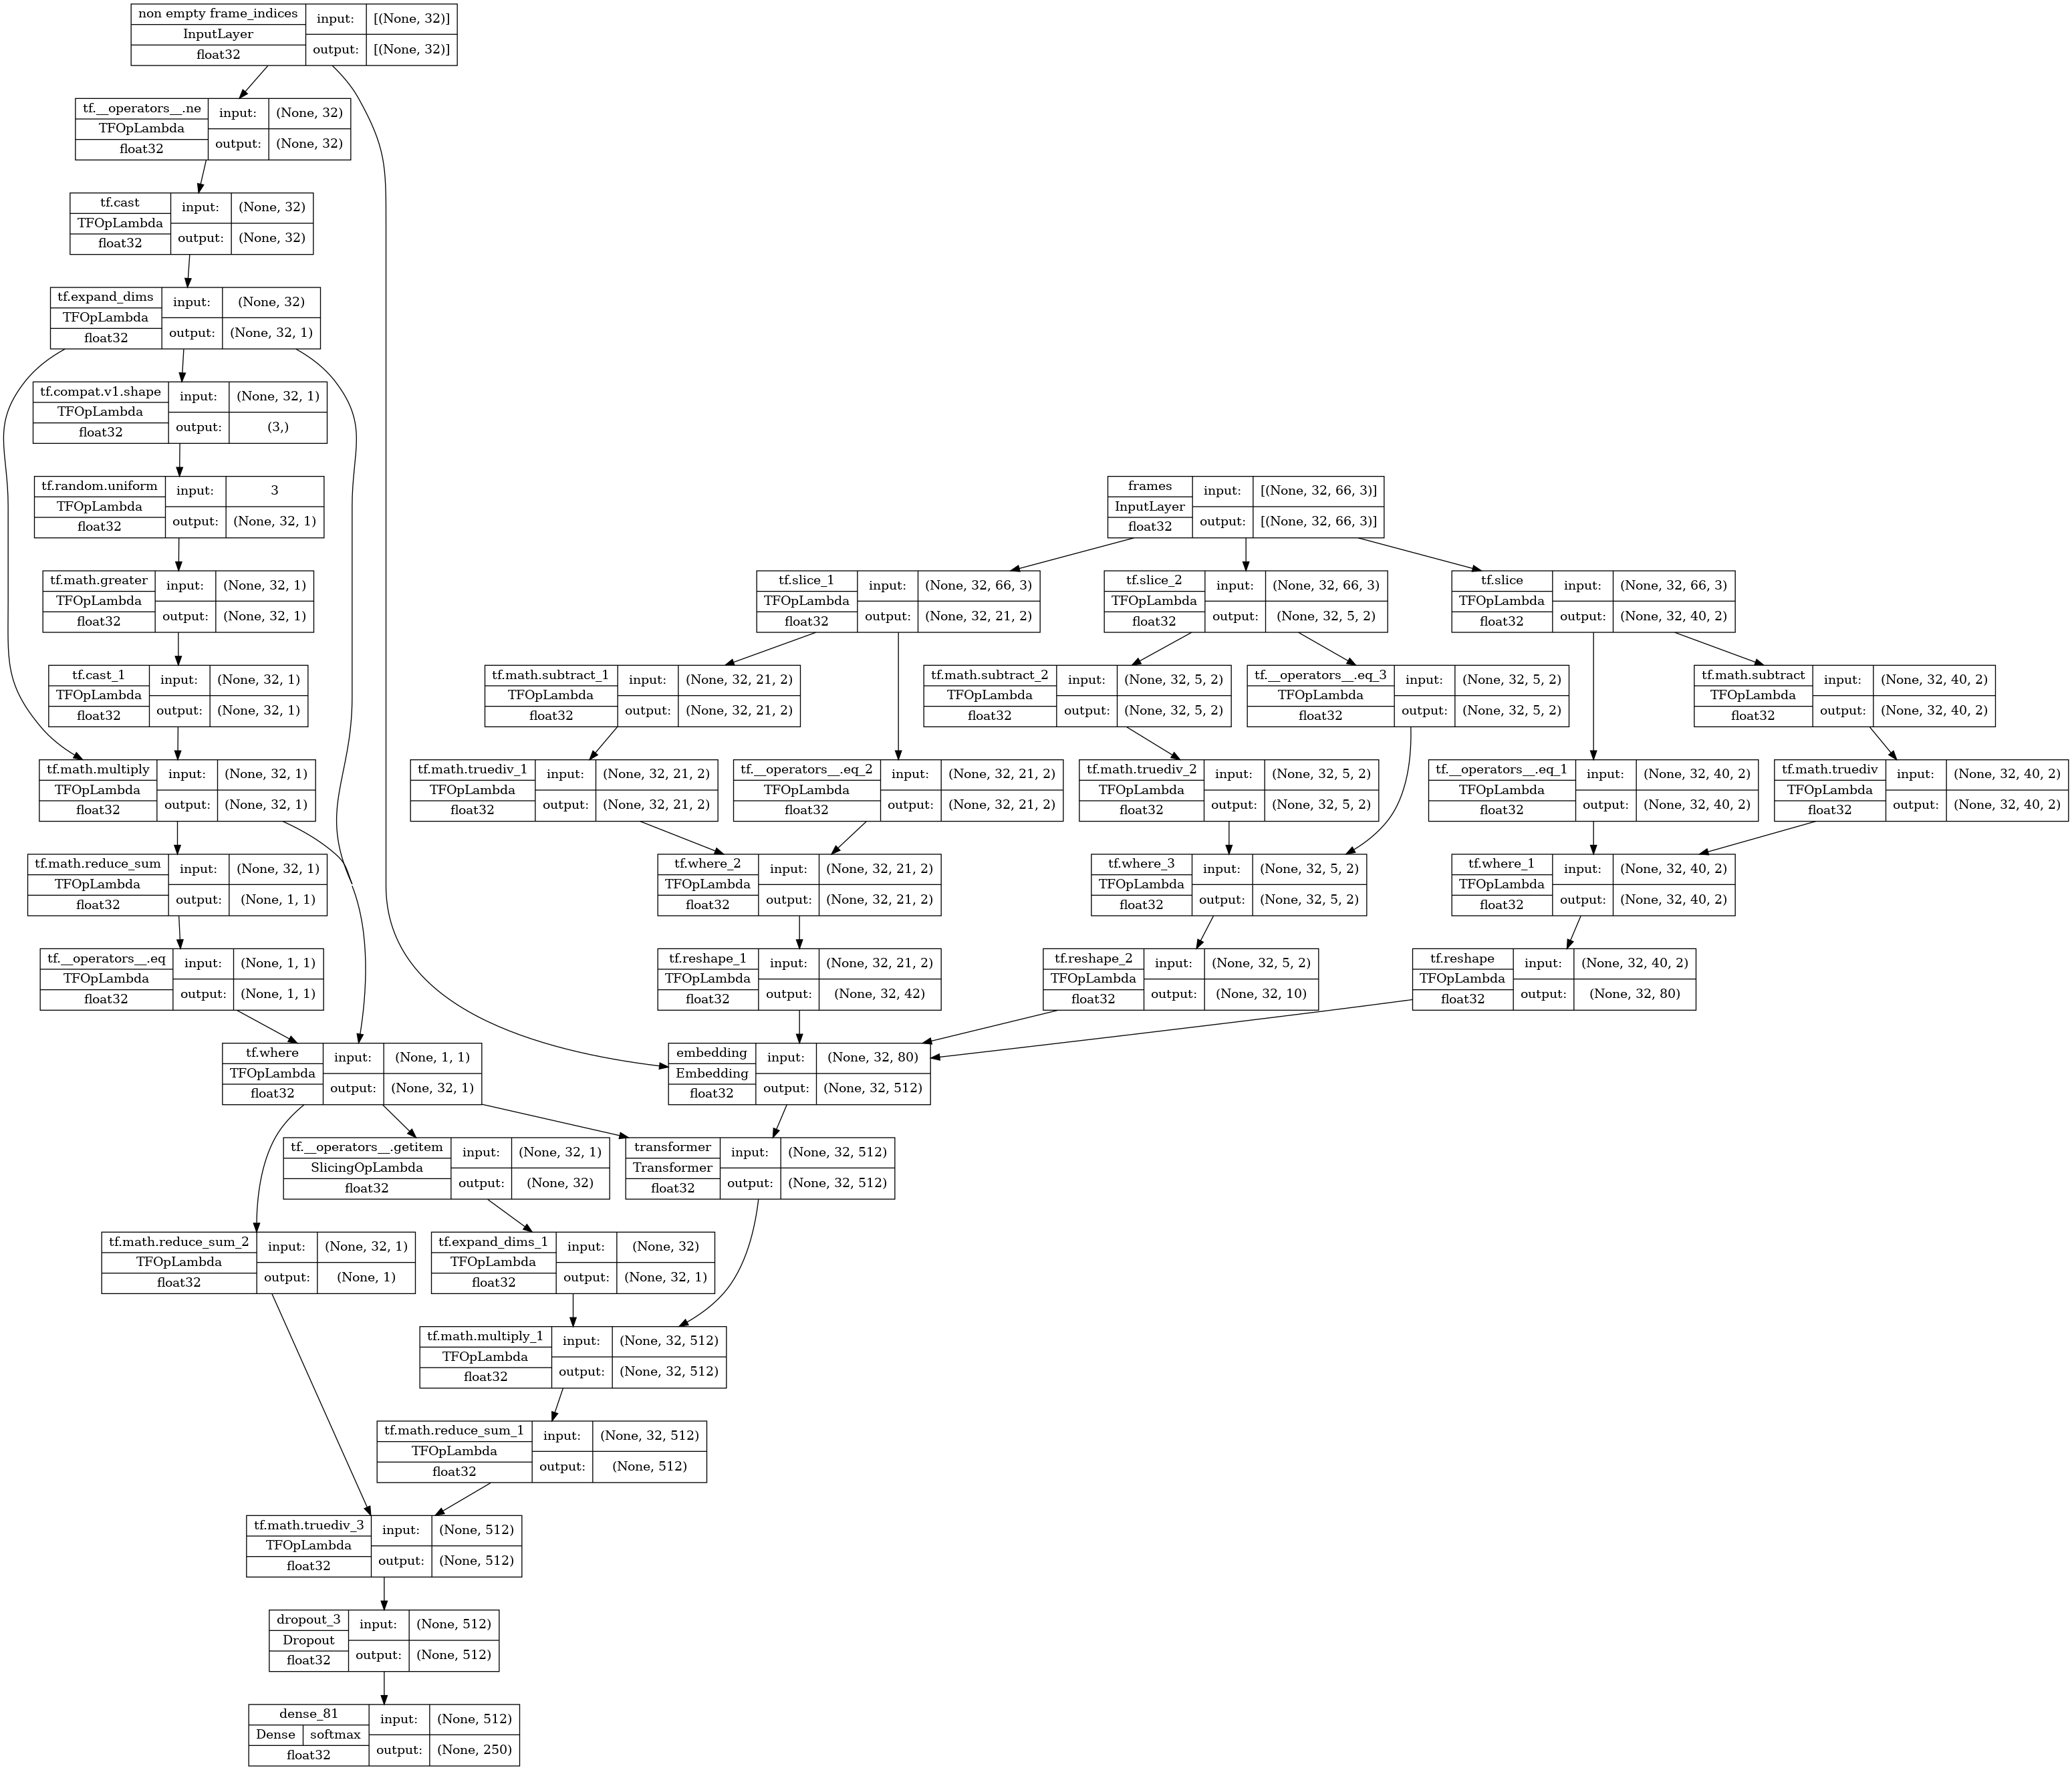

In [25]:
tf.keras.utils.plot_model(model, show_shapes=True, show_dtype=True, show_layer_names=True, expand_nested=True, show_layer_activations=True)

# Learning Rate Scheduler

In [26]:
def learning_rate(current_step, num_warmup_steps, lr_limit, num_cycles=0.50, num_training_steps=model_epochs):
    current_step = tf.cast(current_step, tf.float32)
    num_warmup_steps = tf.cast(num_warmup_steps, tf.float32)
    num_training_steps = tf.cast(num_training_steps, tf.float32)
    
    # Compute warmup learning rate using exponential increase
    warmup_lr = lr_limit * tf.pow(0.10, (num_warmup_steps - current_step))

    # After warmup, apply cosine decay to the learning rate
    progress = (current_step - num_warmup_steps) / tf.maximum(1.0, num_training_steps - num_warmup_steps)
    cosine_decay = 0.5 * (1.0 + tf.cos(tf.constant(math.pi) * num_cycles * 2.0 * progress))
    decayed_lr = lr_limit * cosine_decay

    # Use a condition to switch between warmup and decay phase
    learning_rate = tf.where(current_step < num_warmup_steps, warmup_lr, decayed_lr)

    return learning_rate

In [27]:
# Learning rate for encoder
LR_SCHEDULE = [learning_rate(step, num_warmup_steps=warmup_epochs, lr_limit=lr_limit, num_cycles=0.50) for step in range(model_epochs)]
# Learning Rate Callback
lr_callback = tf.keras.callbacks.LearningRateScheduler(lambda step: LR_SCHEDULE[step])

# Weight Decay Callback

In [28]:
class WeightDecayCallback(tf.keras.callbacks.Callback):
    def __init__(self, wt_decay_ratio=wt_decay_ratio):
        super(WeightDecayCallback, self).__init__()
        self.wt_decay_ratio = wt_decay_ratio
    
    def on_epoch_begin(self, epoch, logs=None):
        # Get the current learning rate from the optimizer
        current_lr = self.model.optimizer.learning_rate
        
        # If the learning rate is a callable (dynamic), compute its current value
        if callable(current_lr):
            current_lr = current_lr(self.model.optimizer.iterations)
        
        # Update weight decay in the optimizer
        self.model.optimizer.weight_decay = current_lr * self.wt_decay_ratio
        
        print(f'learning rate: {current_lr.numpy():.2e}, weight decay: {self.model.optimizer.weight_decay.numpy():.2e}')


# Train

In [29]:
def get_train_batch_all_signs(X, y, frame_indices, n=batch_signs):
    # Precompute the indices for each class only once to avoid repetitive computation
    CLASS2IDXS_dict = {i: np.flatnonzero(y == i) for i in range(classes)}

    # Initialize arrays to store batch data
    X_batch = np.zeros([classes * n, inputSize, num_columns, dim], dtype=np.float32)
    y_batch = np.repeat(np.arange(classes), n)
    frame_indices_batch = np.zeros([classes * n, inputSize], dtype=np.float32)
    
    while True:
        # Randomly select indices for each class to create a balanced batch
        for i, idxs in CLASS2IDXS_dict.items():
            selected_idxs = np.random.choice(idxs, n, replace=len(idxs) < n)
            batch_start = i * n
            batch_end = batch_start + n
            X_batch[batch_start:batch_end] = X[selected_idxs]
            frame_indices_batch[batch_start:batch_end] = frame_indices[selected_idxs]

        yield {'frames': X_batch, 'non empty frame_indices': frame_indices_batch}, y_batch


In [30]:
tf.keras.backend.clear_session

# Actual Training
history = model.fit(
        x=get_train_batch_all_signs(X_train, y_train, frame_indices_TRAIN),
        steps_per_epoch=len(X_train) // (classes * batch_signs),
        epochs=model_epochs,
        # Only used for validation data since training data is a generator
        batch_size=batch_size,
        validation_data=validation_data,
        callbacks=[
            lr_callback,
            WeightDecayCallback(),
        ]
    )

learning rate: 1.00e-03, weight decay: 5.00e-05
Epoch 1/100
80/80 [==============================] - 63s 505ms/step - loss: 5.4656 - acc: 0.1696 - top_5_acc: 0.3670 - top_10_acc: 0.4677 - val_loss: 3.6949 - val_acc: 0.4295 - val_top_5_acc: 0.7564 - val_top_10_acc: 0.8511 - lr: 0.0010
learning rate: 1.00e-03, weight decay: 5.00e-05
Epoch 2/100
80/80 [==============================] - 37s 458ms/step - loss: 3.5560 - acc: 0.5069 - top_5_acc: 0.7741 - top_10_acc: 0.8428 - val_loss: 3.2376 - val_acc: 0.5954 - val_top_5_acc: 0.8523 - val_top_10_acc: 0.9095 - lr: 9.9975e-04
learning rate: 9.99e-04, weight decay: 5.00e-05
Epoch 3/100
80/80 [==============================] - 37s 458ms/step - loss: 3.1575 - acc: 0.6396 - top_5_acc: 0.8580 - top_10_acc: 0.9012 - val_loss: 3.0802 - val_acc: 0.6398 - val_top_5_acc: 0.8744 - val_top_10_acc: 0.9224 - lr: 9.9901e-04
learning rate: 9.98e-04, weight decay: 4.99e-05
Epoch 4/100
80/80 [==============================] - 37s 459ms/step - loss: 2.9691 - acc:

In [31]:
y_val_pred = model.predict({ 'frames': X_val, 'non empty frame_indices': frame_indices_VAL }, verbose=2).argmax(axis=1)
labels = [ORD2SIGN_dict.get(i).replace(' ', '_') for i in range(classes)]

446/446 - 9s - 9s/epoch - 20ms/step


# Classification Report

In [32]:
classification_report = sklearn.metrics.classification_report(y_val,
                                                              y_val_pred,
                                                              target_names=labels,
                                                              output_dict=True)
print(classification_report)

{'TV': {'precision': 0.8181818181818182, 'recall': 0.9, 'f1-score': 0.8571428571428572, 'support': 60}, 'after': {'precision': 0.4666666666666667, 'recall': 0.23728813559322035, 'f1-score': 0.3146067415730337, 'support': 59}, 'airplane': {'precision': 0.9491525423728814, 'recall': 0.9824561403508771, 'f1-score': 0.9655172413793103, 'support': 57}, 'all': {'precision': 0.8541666666666666, 'recall': 0.6949152542372882, 'f1-score': 0.7663551401869159, 'support': 59}, 'alligator': {'precision': 0.7678571428571429, 'recall': 0.7049180327868853, 'f1-score': 0.7350427350427351, 'support': 61}, 'animal': {'precision': 0.6904761904761905, 'recall': 0.6041666666666666, 'f1-score': 0.6444444444444444, 'support': 48}, 'another': {'precision': 0.7647058823529411, 'recall': 0.7647058823529411, 'f1-score': 0.7647058823529412, 'support': 51}, 'any': {'precision': 0.6233766233766234, 'recall': 0.8275862068965517, 'f1-score': 0.711111111111111, 'support': 58}, 'apple': {'precision': 0.9565217391304348, 

# Training History

In [33]:
def plot_history_metric(metric, f_best=np.argmax, ylim=None, yscale=None, yticks=None):
    plt.figure(figsize=(10, 5))
    
    values = history.history[metric]
    model_epochs = len(values)
    epochs = np.arange(1, model_epochs + 1)

    # Check if validation data exists
    val_key = f'val_{metric}'
    has_val = val_key in history.history
    
    # Plot training data
    plt.plot(epochs, values, label='Train', marker='o', linestyle='-')
    best_idx = f_best(values)
    plt.scatter(best_idx + 1, values[best_idx], color='red', s=100, label='Best Train')

    # Plot validation data if available
    if has_val:
        val_values = history.history[val_key]
        plt.plot(epochs, val_values, label='Validation', marker='o', linestyle='--')
        val_best_idx = f_best(val_values)
        plt.scatter(val_best_idx + 1, val_values[val_best_idx], color='green', s=100, label='Best Validation')

    # Set plot titles and labels
    plt.title(f'Model {metric.capitalize()} over Epochs', fontsize=16)
    plt.xlabel('Epoch', fontsize=14)
    plt.ylabel(metric.capitalize(), fontsize=14)
    
    # Apply custom settings
    if ylim:
        plt.ylim(ylim)
    if yscale:
        plt.yscale(yscale)
    if yticks:
        plt.yticks(yticks)

    # Improve tick settings
    plt.xticks(epochs, fontsize=12)
    plt.yticks(fontsize=12)
    plt.legend(fontsize=12)
    plt.grid(True)
    plt.tight_layout()
    plt.show()

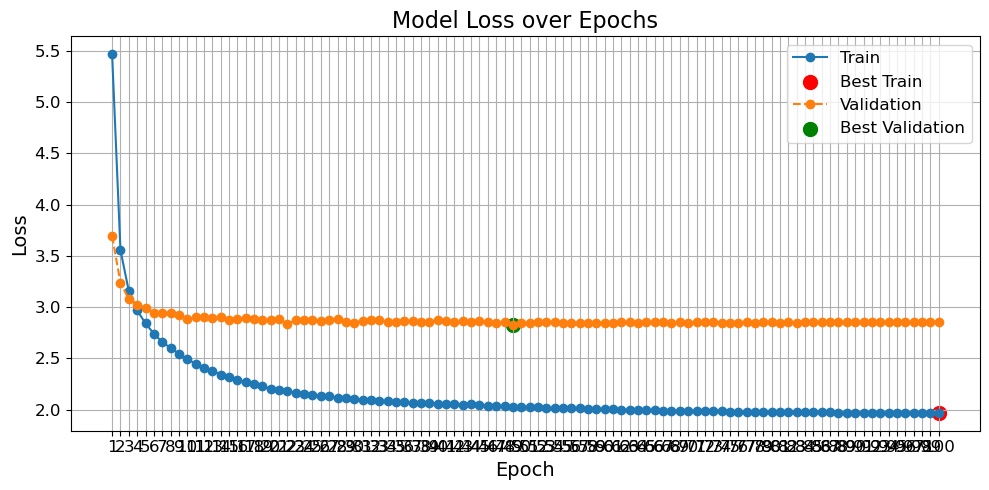

In [34]:
plot_history_metric('loss', f_best=np.argmin)

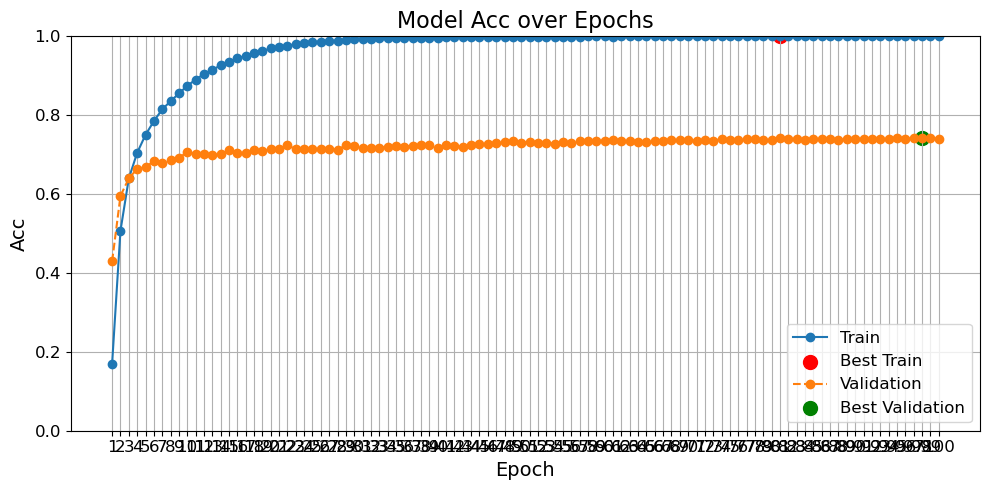

In [35]:
plot_history_metric('acc', ylim=[0,1])

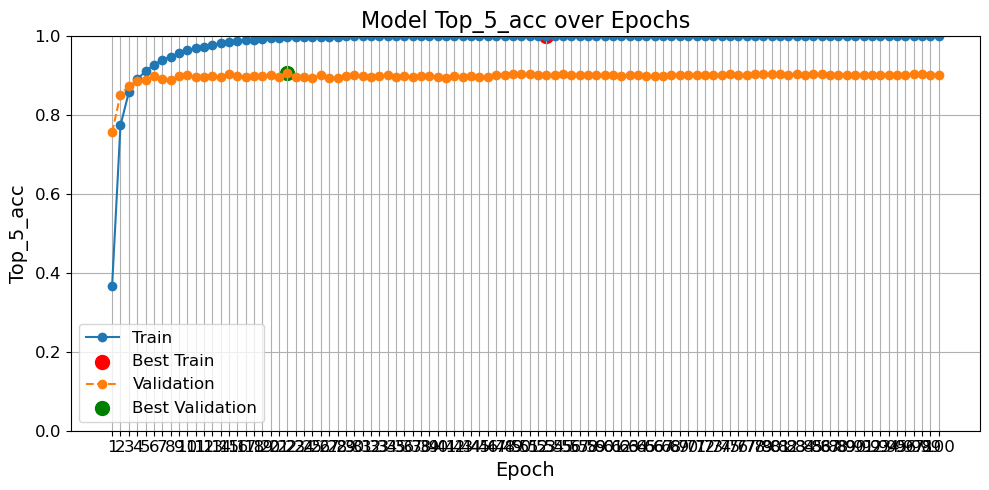

In [36]:
plot_history_metric('top_5_acc', ylim=[0,1])

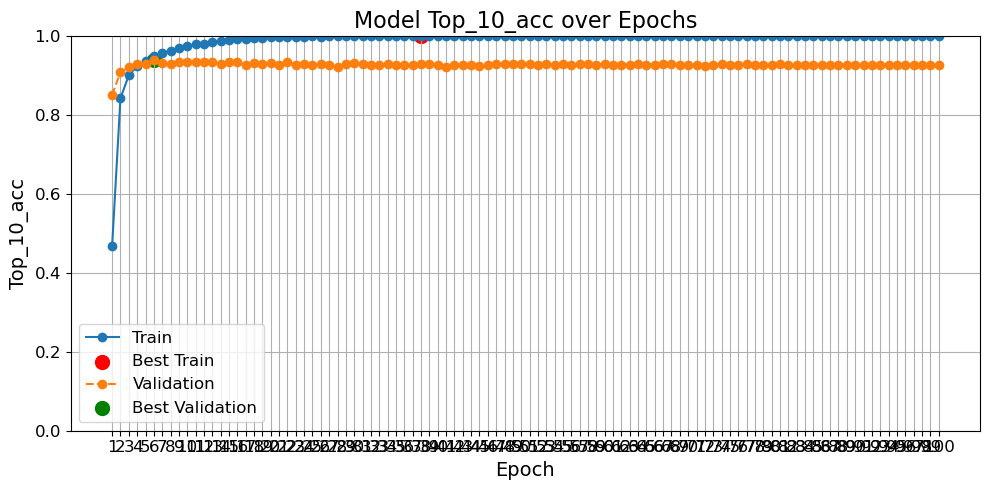

In [37]:
plot_history_metric('top_10_acc', ylim=[0,1])